In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)


In [3]:
## Filter data

from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

In [4]:
ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

ward_profiles.head(5)

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,City of London,00AA,E09000001,8100,650,6250,1250,8.0,76.9,15.2,...,662.9,210.5,656.4,85.3,0.4,18.6,0.4,7.9,5.3,48.5
1,Barking and Dagenham - Abbey,00ABFX,E05000026,14750,3850,10150,750,26.0,69.0,5.0,...,682.6,208.9,138.1,42.2,1.4,21.9,0.5,6.0,0.8,25.7
2,Barking and Dagenham - Alibon,00ABFY,E05000027,10600,2700,6800,1050,25.7,64.3,10.0,...,627.9,201.6,73.6,27.3,0.7,20.6,0.8,3.1,1.0,20.3
3,Barking and Dagenham - Becontree,00ABFZ,E05000028,12700,3200,8350,1100,25.4,65.9,8.7,...,632.0,207.9,79.9,27.6,1.2,1.9,0.9,2.9,1.6,22.5
4,Barking and Dagenham - Chadwell Heath,00ABGA,E05000029,10400,2550,6400,1450,24.3,61.5,14.2,...,613.9,210.5,76.1,24.6,1.3,56.0,0.9,2.3,1.2,25.3


In [5]:
##--Wards Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]

wards.head(5)

,GSS_CODE,HECTARES,geometry
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4..."
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5..."
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ..."
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52..."


In [6]:
##--POIs Data--##
##Selecting pubs, restaurants, cafes

gpkg_path = "data/London_Points_Of_Interest.gpkg"

# Read the GeoPackage into a GeoDataFrame
gdf = gpd.read_file(gpkg_path)

# Define the list of desired classnames
desired_classes = ["Pubs, Bars and Inns", "Cafes, Snack Bars and Tea Rooms", "Restaurants"]

# Filter the GeoDataFrame
poi_data = gdf[gdf['classname'].isin(desired_classes)]

# Display the result
print(poi_data)

            id     ref_no                            name pointx_class  \
6682      8137   19521780        Heston West Service Area     01020043   
6685      8142   19521779        Heston East Service Area     01020043   
6703      8167   18857214  Welcome Break (London Gateway)     01020043   
51122    62532   78527081                Hollydale Tavern     01020034   
65496    79353  157767852             The Diner in London     01020043   
...        ...        ...                             ...          ...   
324257  390991  118149604                          Sami's     01020034   
324258  390992  118149728                           Roxie     01020034   
324259  390993  124036871        Strongroom Bar & Kitchen     01020034   
324260  390994  118152258                      The Graces     01020034   
324261  390995  124756747                      The Garden     01020034   

                                 groupname         categoryname  \
6682    Accommodation, Eating and Drinking  

In [7]:
##--Pubs Data--##
##NOTE: No longer relevant for analysis

pubs = gpd.read_file("data/pubs.geojson").to_crs(epsg=27700)
pubs["geometry"] = pubs.geometry.centroid

pubs = pubs[["name","geometry"]]

pubs.head(5)

,name,geometry
0,The Queens,POINT (530228.555 188568.967)
1,The Gilpin's Bell,POINT (534047.067 191909.103)
2,The Ship and Shovell,POINT (530236.721 180413.513)
3,Crown and Sceptre,POINT (522498.283 179750.168)
4,Princess Victoria,POINT (522169.523 180067.4)


## merging

In [8]:
merged = wards.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

merged = gpd.GeoDataFrame(merged, crs = "EPSG:27700")

merged.head(5)

,GSS_CODE,HECTARES,geometry,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",Kingston upon Thames - Chessington South,00AXGC,E05000405,10550,2200,6800,1500,...,643.4,203.6,47.5,16.3,0.6,75.7,1.4,2.4,2.3,30.4
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4...",Kingston upon Thames - Tolworth and Hook Rise,00AXGM,E05000414,10650,2150,7050,1450,...,714.3,213.3,53.7,14.2,0.7,33.1,1.2,2.3,2.9,32.1
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5...",Kingston upon Thames - Berrylands,00AXFY,E05000401,9800,1800,6500,1500,...,733.7,212.9,31.6,8.2,0.3,10.9,1.0,2.8,4.6,38.0
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ...",Kingston upon Thames - Alexandra,00AXFX,E05000400,9700,1900,6200,1600,...,762.2,215.2,34.7,7.9,0.3,43.7,1.4,2.2,3.9,36.3
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52...",Kingston upon Thames - Beverley,00AXFZ,E05000402,10450,2200,6900,1350,...,761.5,219.3,64.5,15.4,0.7,26.4,1.0,2.8,4.4,41.2


In [9]:
#merged["n_pubs"] = merged.geometry.apply(lambda geom: sum(pubs.geometry.intersects(geom)))
#merged["pub_density"] = merged["n_pubs"] / merged["HECTARES"]

merged["n_poi"] = merged.geometry.apply(lambda geom: sum(pubs.geometry.intersects(geom)))
merged["poi_density"] = merged["n_poi"] / merged["HECTARES"]

merged["n_airbnb"] = merged.geometry.apply(lambda geom: sum(filtered_airbnb.geometry.intersects(geom)))
merged["airbnb_density"] = merged["n_airbnb"] / merged["HECTARES"]



<Axes: >

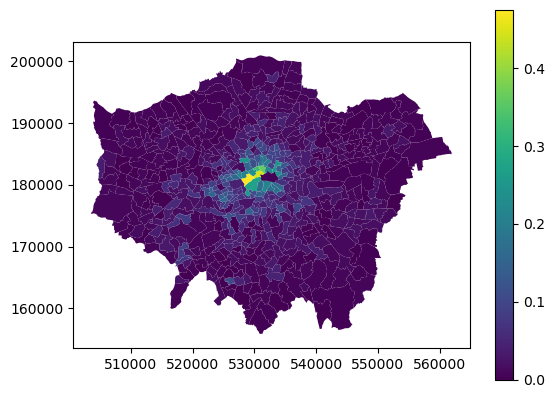

In [16]:
merged.plot(column = "poi_density", cmap="viridis", legend = True)

In [12]:
merged.sort_values(by='poi_density', ascending=False).head(5)

,GSS_CODE,HECTARES,geometry,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,...,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012,n_poi,poi_density,n_airbnb,airbnb_density
484,E05000649,199.973,"POLYGON ((529928.5 181049, 529921.3 181039.1, ...",Westminster - West End,00BKGW,E05000649,11250,950,8950,1300,...,0.4,3.9,0.4,8.0,3.4,29.7,95,0.475064,173,0.865117
502,E05000138,119.493,"POLYGON ((529928.5 181049, 529927.7 181049.5, ...",Camden - Holborn and Covent Garden,00AGGP,E05000138,13700,1750,10550,1400,...,0.1,7.5,0.3,7.9,5.2,37.2,53,0.443541,88,0.736445
533,E05000370,93.263,"POLYGON ((530510 183011.6, 530546.8 183018.6, ...",Islington - Clerkenwell,00AUGB,E05000370,12350,1450,9850,1000,...,0.2,9.3,0.4,6.9,8.4,34.9,34,0.364560,35,0.375283
506,E05000141,61.138,"POLYGON ((530326.1 182983.3, 530364.8 182991.4...",Camden - King's Cross,00AGGS,E05000141,12550,1600,10000,950,...,0.3,13.5,0.2,7.8,7.0,32.8,20,0.327129,36,0.588832
478,E05000644,346.379,"POLYGON ((530410.6 178958.5, 530281.3 178974.1...",Westminster - St. James's,00BKGQ,E05000644,12050,1100,9650,1350,...,0.6,30.7,0.4,7.6,3.6,31.5,95,0.274266,146,0.421504


In [17]:
merged.to_file("data/ward_airbnb.gpkg", driver="GPKG")


### Some plots !

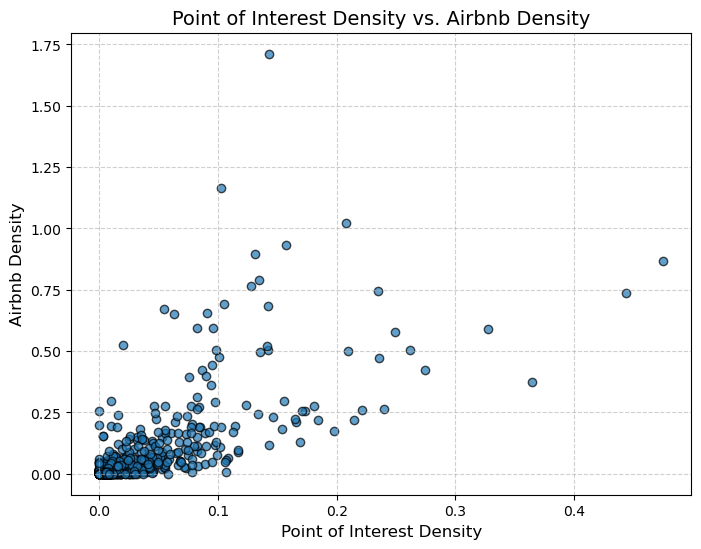

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(merged['poi_density'], merged['airbnb_density'], alpha=0.7, edgecolor='k')
plt.title("Point of Interest Density vs. Airbnb Density", fontsize=14)
plt.xlabel("Point of Interest Density", fontsize=12)
plt.ylabel("Airbnb Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged['Average Public Transport Accessibility score - 2014'], merged['airbnb_density'], alpha=0.7, edgecolor='k')
plt.title("Public Transport Accessibility vs. Airbnb Density", fontsize=14)
plt.xlabel("Public Transport Accessibility", fontsize=12)
plt.ylabel("Airbnb Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged['(ID2010) - Rank of average score (within London) - 2010'], merged['airbnb_density'], alpha=0.7, edgecolor='k')
plt.title("Deprivation vs. Airbnb Density", fontsize=14)
plt.xlabel("Deprivation Rank", fontsize=12)
plt.ylabel("Airbnb Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#LOWER RANK = MORE DEPRIVATION!